## Testing the model using webcam image

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, f1_score, classification_report

### Defining people who the model knows

In [31]:
# Set the directory where the data is stored
data_dir = "Data/People_we_know"

# Define the labels
labels= os.listdir(data_dir)

# Definitions 
img_width, img_height = 128, 128

In [32]:
# Creating a list of images and their label
Images_list = []
Target_list = []

for label in labels:
    path = os.path.join(data_dir, label)
    img_name= os.listdir(path)[0] 
    if img_name != []:
        Images_list.append(os.path.join(path, img_name))
        Target_list.append(label)
Images_list= np.array(Images_list)
Target_list= np.array(Target_list)
print('Dataset Shape: ', Images_list.shape)

Dataset Shape:  (7,)


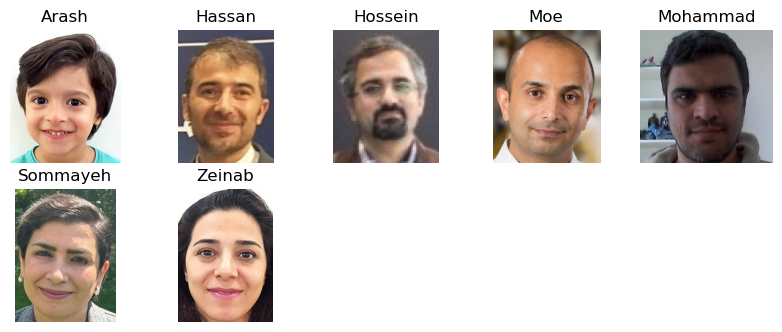

In [33]:
# Plot the images
plt.figure(figsize=(10, 10))
for i in range(min(25,len(labels))):
    plt.subplot(5, 5, i + 1)
    image = Image.open(Images_list[i])
    plt.imshow(image)
    plt.title(f"{Target_list[i]}")
    plt.axis('off')
plt.show()

In [34]:
# Function to load and preprocess images
def load_images(image_path, img_width, img_height):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (img_width, img_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize pixel values
    return np.array(image)

In [35]:
# Load and preprocess images
known_images= np.array([load_images(img, img_width, img_height) for img in Images_list])

### Importing the model

In [36]:
# Load the saved model
save_dir = 'Saved Models'
model_name = 'Face-Detection-Training-CNN-Model-5.h5'

model = load_model(os.path.join(save_dir, model_name))

In [37]:
# Importing the Generator model
def Generator_model(image_input):
    
    # First convolutional block
    x1= model.layers[2](image_input)
    x1= model.layers[3](x1)
    x1= model.layers[4](x1)
    x1= model.layers[5](x1)
    
    # Second convolutional block
    x2= model.layers[6](x1)
    x2= model.layers[7](x2)
    x2= model.layers[8](x2)

    x3= model.layers[9](x2)
    x3= model.layers[10](x3)
    x3= model.layers[11](x3)
    
    # skip connection
    x3= model.layers[12]([x2, x3])
    x3= model.layers[13](x3)
    
    # Third convolutional block
    x4= model.layers[14](x3)
    x4= model.layers[15](x4)
    x4= model.layers[16](x4)

    x5= model.layers[17](x4)
    x5= model.layers[18](x5)
    x5= model.layers[19](x5)

    # skip connection
    x5= model.layers[20]([x4, x5])
    x5= model.layers[21](x5) 
    
    # Fourth convolutional block
    x6= model.layers[22](x5) 
    x6= model.layers[23](x6) 
    x6= model.layers[24](x6) 
    x6= model.layers[25](x6) 
    
    # Flatten and dense layers
    x7= model.layers[26](x6)
    
    return x7

In [38]:
# Defining the embedding / latent vector of known people
known_images_embeddings= []
for image in known_images:
    Embed= Generator_model(image.reshape(1, img_width, img_height, 3))
    known_images_embeddings.append(Embed)

known_images_embeddings= np.array(known_images_embeddings)
known_images_embeddings.shape

(7, 1, 8192)

In [39]:
# Importing the Discriminator model
def discriminator_model(x1, x2):
    X1= model.layers[28](x1 - x2)
    X2= model.layers[29](X1)
    X3= model.layers[30](X2)
    return X3

### Taking a new image for testing the model using webcam

In [40]:
def capture_image():
    cap = cv2.VideoCapture(0)  # Use webcam (index 0)
    print('Please press the "q" key to take a picture!')

    while True:
        ret, frame = cap.read()
        height, width, _ = frame.shape

        # Calculate the crop region
        crop_size = 350
        crop_x = max(int((width - crop_size) / 2), 0)
        crop_y = max(int((height - crop_size) / 2), 0)

        # Draw a yellow square around the crop region
        cv2.rectangle(frame, (crop_x-2, crop_y-2), (crop_x + crop_size+2, crop_y + crop_size+2), (0, 255, 255), 2)

        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to capture the image
            # Crop the image
            cropped_image = frame[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]

            # Save the cropped image
            cv2.imwrite('Data/webcam_image.jpg', cropped_image)
            break

    cap.release()
    cv2.destroyAllWindows()
    print('Thanks! The image is captured and saved.')

In [38]:
# Capture an image from the webcam
capture_image()

Please press the "q" key to take a picture!
Thanks! The image is captured and saved.


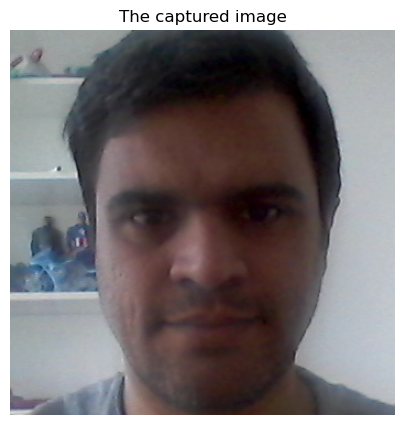

In [41]:
# Plot the captured image
plt.figure(figsize=(5, 5))
captured_image = Image.open('Data/webcam_image.jpg')
plt.imshow(captured_image)
plt.title("The captured image")
plt.axis('off')
plt.show()

In [42]:
# Preprocess + creating the embedding of the captured image 
webcam_image = 'Data/webcam_image.jpg'
webcam_image_processed= load_images(webcam_image, img_width, img_height)
webcam_image_Embed= Generator_model(webcam_image_processed.reshape(1, img_width, img_height, 3))

webcam_image_Embed.shape

TensorShape([1, 8192])

In [43]:
# Compare face images with the webcam image using discriminator_model
similarities = []

for known_embedding in known_images_embeddings:
    similarity = discriminator_model(known_embedding, webcam_image_Embed)
    similarities.append(similarity)
    
Target= np.argmax(similarities)

# Check if any of the similarities indicate a match
if max(similarities) > 0.5:
    print(f"Welcome Mr/Mrs {Target_list[Target]}")
else:
    print("The captured image by webcam does not match any of the known images.")

Welcome Mr/Mrs Mohammad


In [44]:
# Checking the similarit of the captured image with image of the model knows
similarities_list= np.array(similarities).reshape(7)
List= np.array([[ Target_list[i], round(similarities_list[i],2)] for i in range(len(similarities))])
print("The result of Detection: ")
print(List)

The result of Detection: 
[['Arash' '0.0']
 ['Hassan' '0.0']
 ['Hossein' '0.5']
 ['Moe' '0.01']
 ['Mohammad' '0.59']
 ['Sommayeh' '0.0']
 ['Zeinab' '0.04']]
